# Proyecto Open Data I
## Radares, y su eficiencia en la CAM
### Recopilación, limpieza y tratamiento de los datos
Este cuaderno pretende enseñar el proceso de limpieza de los datos relativos a los radares en la CAM
_Paula Gómez Lucas, Alejandro Majado Martínez_

In [1]:
# Importar librerías
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

A continuación, se muestra la clase que está compuesta de todos los métodos que se encargan de la limpieza y transformación de los datos

In [2]:
class CSVDataLoader:
    """
    A class for loading and cleaning CSV data from a specified folder path.

    Attributes:
    -----------
    folder_path : str
        The path to the folder containing the CSV files to be loaded.

    data : dict
        A dictionary containing the loaded CSV data, where the keys are the file names and the values are the corresponding dataframes.
    """

    def __init__(self, folder_path):
        """
        Initializes a CSVDataLoader object with the specified folder path.

        Parameters:
        -----------
        folder_path : str
            The path to the folder containing the CSV files to be loaded.
        """
        self.folder_path = folder_path
        self.data = {}
        self.filename = []
        self.keys = []

    def load_data(self):
        """
        Loads CSV data from the specified folder path into a dictionary.

        Returns:
        --------
        None
        """
        csv_files = [f for f in os.listdir(self.folder_path) if f.endswith('.csv')]
        folders = ("datasets/actuacionesBomberos", "datasets/estaciones", "datasets/accidentalidad")
        for folder in folders:
            df = None
            for file in os.listdir(folder):
                filepath = folder + "/" + file
                df1 = pd.read_csv(filepath, sep=';', encoding='utf-8', low_memory=False)
                df = pd.concat([df, df1])
            self.data[str(folder)] = df

        for file_name in csv_files:
            file_path = os.path.join(self.folder_path, file_name)
            try:
                df = pd.read_csv(file_path, sep=';', encoding='latin-1', low_memory=False)
                self.data[str(file_name)] = df
                self.filename.append(file_name)
            except Exception as e:
                print(f"Error al leer {file_name}: {str(e)}")

        for value in self.data.keys():
            self.keys.append(value)

    def clean_data(self):
        """
        Cleans the loaded CSV data by renaming columns, removing whitespace, dropping null values and duplicates, and converting date columns to datetime format.

        Returns:
        --------
        None
        """
        columna_borrar = "Unnamed"
        for df in self.data:
            for j in self.data[df].columns:
                if columna_borrar in j:
                    while j in self.data[df].columns:
                        self.data[df] = self.data[df].drop(j, axis=1)
                        self.data[df] = self.data[df].dropna(how='all', axis=0)
                        
            self.data[df] = self.data[df].rename(columns = lambda x: x.strip().lower().replace(' ', '_'))
            self.data[df] = self.data[df].map(lambda x: x.strip() if isinstance(x, str) else x)
            self.data[df] = self.data[df].dropna(how='all', axis=0)
            self.data[df] = self.data[df].drop_duplicates()
            self.data[df] = self.data[df].loc[:, ~self.data[df].columns.duplicated()]
            self.data[df].columns = map(str.upper, self.data[df].columns)

            if 'FECHA' in self.data[df].columns:
                self.data[df]['FECHA'] = pd.to_datetime(self.data[df]['FECHA'], format='%d/%m/%Y')

#           num_cols = self.data[i].select_dtypes(include='number').columns
#           for col in num_cols:
#               self.data[i][col] = self.data[i][col].fillna(self.data[i][col].mean())

    def get_info(self, filename):
        print(self.data[filename].isnull().sum())
        print(self.data[filename].info())
        
    def get_nan_columns(self):
        j = 0
        for i in self.data:
            print(self.keys[j])
            self.get_info(i)
            j+=1
      
    def get_cleaned_data(self):
        """
        Returns the cleaned CSV data as a dictionary.

        Returns:
        --------
        dict
            A dictionary containing the cleaned CSV data, where the keys are the file names and the values are the corresponding dataframes.
        """
        return self.data

    def create_graph(df, colummn, name):
        frec = df[''+str(colummn)].value_counts()
        aux_df = pd.DataFrame(frec)
        aux_df.columns = ["Frecuencia absoluta"]
        aux_df["Frecuencia relativa"] = 100*aux_df["Frecuencia absoluta"] / len(df)
        frec_rel_cumsum = aux_df["Frecuencia relativa"].cumsum()
        aux_df["Frecuencia relativa acumulada"] = frec_rel_cumsum
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        ax.set_title('Distribución de '+ str(name))
        ax.bar(aux_df.index, aux_df['Frecuencia absoluta'], color='blue')
        ax2 = ax.twinx()
        ax2.plot(aux_df.index, aux_df['Frecuencia relativa acumulada'], color='red', marker='o', ms = 5)
        ax2.yaxis.set_major_formatter(PercentFormatter())
        ax.tick_params(axis='y', color = 'blue')
        ax2.tick_params(axis='y', color = 'red')
        ax.set_xticklabels(aux_df.index, rotation=90)
        plt.show()

Una vez está definida la clase con sus métodos, procedemos a declarar las variables que nos permiten trabajar con ello

In [3]:
folder_path = "datasets"
data_loader = CSVDataLoader(folder_path)

La siguiente función carga los datos de los csv a los dataframes

In [4]:
data_loader.load_data()

Limpiamos los datos eliminando las columnas autogeneradas con NaNs, renombramos las columnas para que sean uniformes (minúsculas y con barra bajas), eliminamos las filas de NaNs, eliminamos las filas duplicadas, formateamos todas las variables fecha para que sean consistentes (dd/mm/aaaa), sustituimos los NaNs de las variables numéricas con la media correspondiente a su variable.

In [5]:
data_loader.clean_data()
data = data_loader.get_cleaned_data()

Por último, para confirmar que los datos se han cargado bien, utilizamos el método get_nan_columns para ver cuántos datos en cada columna quedan nulos, así como usamos el método info() de pandas para ver un resumen de todas las columnas y comprobamos también que todo el formateo de las columnas se ha realizado sin problema.

In [6]:
data_loader.get_nan_columns()

datasets/actuacionesBomberos
AÑO                         0
MES                         0
DISTRITO                    0
FUEGOS                      0
DAÑOS_EN_CONSTRUCCION       0
SALVAMENTOS_Y_RESCATES      0
DAÑOS_POR_AGUA              0
INCIDENTES_DIVERSOS         0
SALIDAS_SIN_INTERVENCION    0
SERVICIOS_VARIOS            0
TOTAL                       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 439 entries, 0 to 262
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   AÑO                       439 non-null    int64 
 1   MES                       439 non-null    object
 2   DISTRITO                  439 non-null    object
 3   FUEGOS                    439 non-null    int64 
 4   DAÑOS_EN_CONSTRUCCION     439 non-null    int64 
 5   SALVAMENTOS_Y_RESCATES    439 non-null    int64 
 6   DAÑOS_POR_AGUA            439 non-null    int64 
 7   INCIDENTES_DIVERSOS       439 non-nul

Efectivamente, se realiza sin problemas. El siguiente paso es el análisis de los datasets columna a columna para revisar qué método usar para rellenar los datos faltantes dependiendo de cada atributo.  

### Sustitución de valores faltantes
Los datasets actuaciones bomberos y estaciones no tienen datos faltantes, por lo que sólo nos queda trabajar con los otros 8 datasets, que podemos observar aquí:

In [7]:
for i in data.keys():
    print(i)

datasets/actuacionesBomberos
datasets/estaciones
datasets/accidentalidad
DireccionesVigentes_20231004.csv
DireccionesEvolucionHistorica_20231004.csv
VialesVigentesDistritosBarrios_20231004.csv
RADARES_FIJOS_vDTT.csv
VialesEvolucionHistorica_20231004.csv
VialesVigentesDistritos_20231004.csv
VialesVigentes_20231004.csv


Empecemos con accidentalidad: 

In [8]:
data_loader.get_info('datasets/accidentalidad')
data_loader.data['datasets/accidentalidad']

NUM_EXPEDIENTE              0
FECHA                       0
HORA                        0
LOCALIZACION                0
NUMERO                      1
COD_DISTRITO                1
DISTRITO                    1
TIPO_ACCIDENTE              1
ESTADO_METEOROLÓGICO     8220
TIPO_VEHICULO             453
TIPO_PERSONA                0
RANGO_EDAD                  0
SEXO                        0
COD_LESIVIDAD           34125
LESIVIDAD               34125
COORDENADA_X_UTM            1
COORDENADA_Y_UTM            1
POSITIVA_ALCOHOL          341
POSITIVA_DROGA          74686
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 74962 entries, 0 to 47052
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   NUM_EXPEDIENTE        74962 non-null  object        
 1   FECHA                 74962 non-null  datetime64[ns]
 2   HORA                  74962 non-null  object        
 3   LOCALIZACION      

,NUM_EXPEDIENTE,FECHA,HORA,LOCALIZACION,NUMERO,COD_DISTRITO,DISTRITO,TIPO_ACCIDENTE,ESTADO_METEOROLÓGICO,TIPO_VEHICULO,TIPO_PERSONA,RANGO_EDAD,SEXO,COD_LESIVIDAD,LESIVIDAD,COORDENADA_X_UTM,COORDENADA_Y_UTM,POSITIVA_ALCOHOL,POSITIVA_DROGA
0,2023S000001,2023-01-01,1:15:00,"AVDA. ALFONSO XIII, 33",33,5.0,CHAMARTÍN,Alcance,Despejado,Todo terreno,Conductor,De 55 a 59 años,Mujer,14.0,Sin asistencia sanitaria,443397.166,4478129.388,N,NaN
1,2023S000001,2023-01-01,1:15:00,"AVDA. ALFONSO XIII, 33",33,5.0,CHAMARTÍN,Alcance,Despejado,Todo terreno,Pasajero,De 21 a 24 años,Hombre,14.0,Sin asistencia sanitaria,443397.166,4478129.388,N,NaN
3,2023S000001,2023-01-01,1:15:00,"AVDA. ALFONSO XIII, 33",33,5.0,CHAMARTÍN,Alcance,Despejado,Todo terreno,Pasajero,De 21 a 24 años,Mujer,7.0,Asistencia sanitaria sólo en el lugar del acci...,443397.166,4478129.388,N,NaN
4,2023S000001,2023-01-01,1:15:00,"AVDA. ALFONSO XIII, 33",33,5.0,CHAMARTÍN,Alcance,Despejado,Todo terreno,Pasajero,De 55 a 59 años,Hombre,7.0,Asistencia sanitaria sólo en el lugar del acci...,443397.166,4478129.388,N,NaN
5,2023S000001,2023-01-01,1:15:00,"AVDA. ALFONSO XIII, 33",33,5.0,CHAMARTÍN,Alcance,Despejado,Turismo,Conductor,De 45 a 49 años,Mujer,14.0,Sin asistencia sanitaria,443397.166,4478129.388,S,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47048,2022S041289,2022-12-29,19:40:00,CALL. GENERAL RICARDOS / plaza de toros,174,11.0,CARABANCHEL,Alcance,Despejado,Turismo,Conductor,De 50 a 54 años,Hombre,14.0,Sin asistencia sanitaria,"437453,757","4470784,586",N,NaN
47049,2022S041289,2022-12-29,19:40:00,CALL. GENERAL RICARDOS / plaza de toros,174,11.0,CARABANCHEL,Alcance,Despejado,Turismo,Pasajero,De 50 a 54 años,Mujer,7.0,Asistencia sanitaria sólo en el lugar del acci...,"437453,757","4470784,586",N,NaN
47050,2022S041312,2022-12-12,22:50:00,AVDA. ANDALUCIA / AVDA. PERLA,14,12.0,USERA,Colisión fronto-lateral,Lluvia débil,Turismo,Conductor,De 21 a 24 años,Mujer,NaN,NaN,"441049,284","4469136,878",N,NaN
47051,2022S041312,2022-12-12,22:50:00,AVDA. ANDALUCIA / AVDA. PERLA,14,12.0,USERA,Colisión fronto-lateral,Lluvia débil,Turismo,Conductor,De 35 a 39 años,Hombre,NaN,NaN,"441049,284","4469136,878",N,NaN


Hay algunos datos faltantes que tiene sentido que lo sean, y podemos sustituir por un buzzword de algún tipo que nos haga saber que se trate de esto, como lo es que en un accidente en el que no se han producido lesiones, la lesividad sea nula y tampoco haya código de la misma, y como ambas cifras coinciden, es lógico pensar que se trata de las mismas situaciones. Podemos sustituir entonces todos los NaNs de Lesividad faltantes por 'Sin asistencia sanitaria' y el código por -1.0.

In [9]:
data_loader.data['datasets/accidentalidad']['LESIVIDAD'] = data_loader.data['datasets/accidentalidad']['LESIVIDAD'].fillna('Sin asistencia sanitaria')
data_loader.data['datasets/accidentalidad']['COD_LESIVIDAD'] = data_loader.data['datasets/accidentalidad']['COD_LESIVIDAD'].fillna(-1.0)

Por otro lado, positivo en droga tiene valor sólo si daba positivo, por lo que rellenar los valores faltantes con 0 es lo más lógico (siendo 0 negativo en droga). 

In [10]:
data_loader.data['datasets/accidentalidad']['POSITIVA_DROGA'] = data_loader.data['datasets/accidentalidad']['POSITIVA_DROGA'].fillna(0)

Número, código de distrito, tipo de accidente, coordenadas (x e y), son atributos a los que sólo les falta un dato cada uno, por lo que no es representativo esta falta de datos y podemos rellenarlos con el valor más habitual. 

In [11]:
numero = data_loader.data['datasets/accidentalidad']['COD_DISTRITO'].mode().iat[0]
codDistrito = data_loader.data['datasets/accidentalidad']['COD_DISTRITO'].mode().iat[0]
distrito = data_loader.data['datasets/accidentalidad']['COD_DISTRITO'].mode().iat[0]
accidente = data_loader.data['datasets/accidentalidad']['COD_DISTRITO'].mode().iat[0]
coorX = data_loader.data['datasets/accidentalidad']['COD_DISTRITO'].mode().iat[0]
coorY = data_loader.data['datasets/accidentalidad']['COD_DISTRITO'].mode().iat[0]


data_loader.data['datasets/accidentalidad']['NUMERO'] = data_loader.data['datasets/accidentalidad']['NUMERO'].fillna(numero)
data_loader.data['datasets/accidentalidad']['COD_DISTRITO'] = data_loader.data['datasets/accidentalidad']['COD_DISTRITO'].fillna(codDistrito)
data_loader.data['datasets/accidentalidad']['DISTRITO'] = data_loader.data['datasets/accidentalidad']['DISTRITO'].fillna(distrito)
data_loader.data['datasets/accidentalidad']['TIPO_ACCIDENTE'] = data_loader.data['datasets/accidentalidad']['TIPO_ACCIDENTE'].fillna(accidente)
data_loader.data['datasets/accidentalidad']['COORDENADA_X_UTM'] = data_loader.data['datasets/accidentalidad']['COORDENADA_X_UTM'].fillna(coorX)
data_loader.data['datasets/accidentalidad']['COORDENADA_Y_UTM'] = data_loader.data['datasets/accidentalidad']['COORDENADA_Y_UTM'].fillna(coorY)


Por último, donde queda dilema es en positivo alcohol, tipo de vehículo y estado meteorológico. En esta situación, lo más apropiado es ver si, relacionando estos atributos con algún otro, es más probable que los atributos valgan uno u otro valor.

- Estado meteorológico. Hay 7 valores posibles: despejado, lluvia débil, lluvia intensa, granizando, nevando, nublado, se desconoce. Aquí, por lo tanto, hay 3 vías de actuación:
    - Rellenar con "se desconoce", i.e.: ser fieles a lo que se sabe, reducir la proporción de datos artificiales (hay un 11% de datos faltantes), solución sencilla.
    - Rellenar con el valor más frecuente: despejado (representa el 75% de los datos), i.e.: solución con datos artificiales más sencilla.
    - Rellenar con valores aleatorios según la proporción en la que aparecen los datos, i.e.: el 75% de los datos faltantes se rellenan arbitrariamente con "Despejado".

    Lo que mejor preserva los datos es, rellenar con "se desconoce", pues la variable existe previamente.

In [12]:
data_loader.data['datasets/accidentalidad']['ESTADO_METEOROLÓGICO'] = data_loader.data['datasets/accidentalidad']['ESTADO_METEOROLÓGICO'].fillna('Se desconoce')

- Tipo de vehículo. Hay 34 valores posibles: Ambulancia SAMUR, autobús EMT, autobús, autobús articulado, autobús articulado EMT, autocaravana, bicicleta, bicicleta EPAC (pedaleo asistido), camión de bomberos, camión rígido, ciclo, ciclomotor, ciclomotor de dos ruedas L1e-B, cuadriciclo ligero, cuadriciclo no ligero, furgoneta, maquinaria de obras, microbús <= 17 plazas, moto de tres ruedas > 125cc, moto de tres ruedas hasta 125cc, motocicleta > 125cc, motocicleta hasta 125cc, otros vehículos con motor, otros vehículos sin motor, patinete no eléctrico, remolque, semirremolque, sin especificar, todo terreno, tractocamión, tren/metro, turismo (68%), VMU eléctrico, vehículo articulado. En esta variable hay 0.6% de valores faltantes, lo cual no es significativo, i.e.: la sustitución que elijamos tendrá menos repercusión en el estudio final. Aquí, por lo tanto, hay 2 vías de actuación:
    - Rellenar con "sin especificar", i.e.: solución sencilla y descriptiva pero que puede dar lugar a interpretaciones erróneas, pues puede haber sido otro tipo de vehículo que no se había registrado.
    - Rellenar con el valor más probable según otro atributo (por ejemplo, código de lesividad).
    
    La solución más apropiada es rellenar con el valor más probable según código de lesividad, por lo que vamos a ver primero cómo se relacionan ambos atributos y después rellenaremos los valores faltantes con el valor más probable.

In [13]:
data_loader.data['datasets/accidentalidad']['TIPO_VEHICULO'] = data_loader.data['datasets/accidentalidad']['TIPO_VEHICULO'].fillna(data_loader.data['datasets/accidentalidad'].groupby('COD_LESIVIDAD')['TIPO_VEHICULO'].transform(lambda x:x.mode().iat[0]))

In [14]:
data_loader.get_info('datasets/accidentalidad')

NUM_EXPEDIENTE            0
FECHA                     0
HORA                      0
LOCALIZACION              0
NUMERO                    0
COD_DISTRITO              0
DISTRITO                  0
TIPO_ACCIDENTE            0
ESTADO_METEOROLÓGICO      0
TIPO_VEHICULO             0
TIPO_PERSONA              0
RANGO_EDAD                0
SEXO                      0
COD_LESIVIDAD             0
LESIVIDAD                 0
COORDENADA_X_UTM          0
COORDENADA_Y_UTM          0
POSITIVA_ALCOHOL        341
POSITIVA_DROGA            0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 74962 entries, 0 to 47052
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   NUM_EXPEDIENTE        74962 non-null  object        
 1   FECHA                 74962 non-null  datetime64[ns]
 2   HORA                  74962 non-null  object        
 3   LOCALIZACION          74962 non-null  object        
 4 

Como podemos comprobar, no quedan datos faltantes. Pasamos a Actuaciones Bomberos:

In [15]:
data_loader.get_info('datasets/actuacionesBomberos')

AÑO                         0
MES                         0
DISTRITO                    0
FUEGOS                      0
DAÑOS_EN_CONSTRUCCION       0
SALVAMENTOS_Y_RESCATES      0
DAÑOS_POR_AGUA              0
INCIDENTES_DIVERSOS         0
SALIDAS_SIN_INTERVENCION    0
SERVICIOS_VARIOS            0
TOTAL                       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 439 entries, 0 to 262
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   AÑO                       439 non-null    int64 
 1   MES                       439 non-null    object
 2   DISTRITO                  439 non-null    object
 3   FUEGOS                    439 non-null    int64 
 4   DAÑOS_EN_CONSTRUCCION     439 non-null    int64 
 5   SALVAMENTOS_Y_RESCATES    439 non-null    int64 
 6   DAÑOS_POR_AGUA            439 non-null    int64 
 7   INCIDENTES_DIVERSOS       439 non-null    int64 
 8   SALIDAS_SIN_

Este dataset no tiene datos faltantes, pasamos al siguiente. Estaciones:

In [16]:
data_loader.get_info('datasets/estaciones')

FDIA     0
FEST     0
FSEN     0
HOR1     0
HOR2     0
HOR3     0
HOR4     0
HOR5     0
HOR6     0
HOR7     0
HOR8     0
HOR9     0
HOR10    0
HOR11    0
HOR12    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 86140 entries, 0 to 7315
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FDIA    86140 non-null  object 
 1   FEST    86140 non-null  object 
 2   FSEN    86140 non-null  object 
 3   HOR1    86140 non-null  float64
 4   HOR2    86140 non-null  float64
 5   HOR3    86140 non-null  float64
 6   HOR4    86140 non-null  float64
 7   HOR5    86140 non-null  float64
 8   HOR6    86140 non-null  float64
 9   HOR7    86140 non-null  float64
 10  HOR8    86140 non-null  float64
 11  HOR9    86140 non-null  float64
 12  HOR10   86140 non-null  float64
 13  HOR11   86140 non-null  float64
 14  HOR12   86140 non-null  float64
dtypes: float64(12), object(3)
memory usage: 10.5+ MB
None


Este dataset tampoco tiene datos faltantes. Pasamos a la evolución histórica de las direcciones:

In [17]:
data_loader.get_info('DireccionesEvolucionHistorica_20231004.csv')

COD_VIA                    0
VIA_SQC               371584
VIA_CLASE                  0
VIA_PAR                17997
VIA_NOMBRE                 0
VIA_NOMBRE_ACENTOS         0
COD_NDP                    0
CLASE_NDP                  0
NÚMERO                     0
CALIFICADOR           322826
FECHA_DE_ALTA              0
FECHA_DE_BAJA         211657
TIPO_NDP               16248
UTMX_ED                    0
UTMY_ED                    0
UTMX_ETRS                  0
UTMY_ETRS                  0
LATITUD                    0
LONGITUD                   0
ANGULO_ROTULACION          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371584 entries, 0 to 371583
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   COD_VIA             371584 non-null  int64  
 1   VIA_SQC             0 non-null       float64
 2   VIA_CLASE           371584 non-null  object 
 3   VIA_PAR             353587 non-null  obje

Como podemos observar, faltan datos de las columnas VIA_SQC (secuencia de la denominación), con 371584 NaNs; VIA_PAR (partícula de la denominación), con 17997; CALIFICADOR (del número de la policía), con 322826; FECHA_DE_BAJA (de la dirección), con 211657; y TIPO_NDP (tipo de número: portal, garaje, fachada, etc.) con 16248.

In [18]:
data_loader.data['DireccionesEvolucionHistorica_20231004.csv']

,COD_VIA,VIA_SQC,VIA_CLASE,VIA_PAR,VIA_NOMBRE,VIA_NOMBRE_ACENTOS,COD_NDP,CLASE_NDP,NÚMERO,CALIFICADOR,FECHA_DE_ALTA,FECHA_DE_BAJA,TIPO_NDP,UTMX_ED,UTMY_ED,UTMX_ETRS,UTMY_ETRS,LATITUD,LONGITUD,ANGULO_ROTULACION
0,127,NaN,CALLE,DE,ISABEL COLBRAND,ISABEL COLBRAND,11049663,NUMERO,2,B,13/10/1992,NaN,PORTAL,"443214,74","4485347,45","443105,38","4485139,98",40°30'54.12'' N,3°40'17.75'' W,"85,86"
1,127,NaN,CALLE,DE,ISABEL COLBRAND,ISABEL COLBRAND,11049663,NUMERO,2,NaN,01/01/1991,13/10/1992,PORTAL,"443214,74","4485347,45","443105,38","4485139,98",40°30'54.12'' N,3°40'17.75'' W,"85,86"
2,127,NaN,CALLE,DE,ISABEL COLBRAND,ISABEL COLBRAND,11049664,NUMERO,4,NaN,01/01/1991,NaN,PORTAL,"443212,21","4485305,01","443102,86","4485097,54",40°30'52.74'' N,3°40'17.85'' W,"86,29"
3,127,NaN,CALLE,DE,ISABEL COLBRAND,ISABEL COLBRAND,20057084,NUMERO,14,NaN,13/10/1992,NaN,PARCELA,"442858,75","4484933,55","442749,39","4484726,08",40°30'40.61'' N,3°40'32.75'' W,"27,04"
4,127,NaN,CALLE,DE,ISABEL COLBRAND,ISABEL COLBRAND,20057087,NUMERO,16,A,06/11/1998,NaN,PORTAL,"442750,17","4484945,03","442640,81","4484737,56",40°30'40.95'' N,3°40'37.36'' W,"16,81"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371579,31006109,NaN,LUGAR,NaN,CAÑADA REAL SECTOR 6,CAÑADA REAL SECTOR 6,31071343,NUMERO,197,B,12/07/2023,NaN,PORTAL,-1,-1,"447989,3","4463631,36",40°19'17.72'' N,3°36'43.89'' W,"63,07"
371580,31006109,NaN,LUGAR,NaN,CAÑADA REAL SECTOR 6,CAÑADA REAL SECTOR 6,31071344,NUMERO,207,NaN,12/07/2023,NaN,PORTAL,"447926,45","4463659,51","447816,87","4463451,88",40°19'11.86'' N,3°36'51.14'' W,"52,82"
371581,31006109,NaN,LUGAR,NaN,CAÑADA REAL SECTOR 6,CAÑADA REAL SECTOR 6,31071345,NUMERO,211,NaN,12/07/2023,NaN,PORTAL,"447806,87","4463509,48","447697,29","4463301,85",40°19'6.97'' N,3°36'56.17'' W,"69,89"
371582,31006109,NaN,LUGAR,NaN,CAÑADA REAL SECTOR 6,CAÑADA REAL SECTOR 6,31071346,NUMERO,213,NaN,12/07/2023,NaN,PORTAL,"447757,71","4463417,13","447648,14","4463209,5",40°19'3.97'' N,3°36'58.22'' W,"53,82"


La secuencia de denominación (VIA_SQC) es solo NaNs, por lo que lo más lógico es eliminar la columna directamente

In [19]:
data_loader.data['DireccionesEvolucionHistorica_20231004.csv'] = data_loader.data['DireccionesEvolucionHistorica_20231004.csv'].drop('VIA_SQC', axis=1)

Ahora, pasamos a la partícula de denominación (VIA_PAR), hay 7 valores distintos de entre la lista posible de 20 (DE, EL, A, DEL, LA, AL, DE LA, LAS, A LA, DE LAS, LO, A LAS, DE LO, LOS, A LO, DE LO, DE LOS, POR EL, A LOS, POR LA), de los cuales el primero es A LA y el último es DEL. Por lo tanto, parece que no se ha rellenado con Null o espacio vacío aquellas direcciones en las que no hay partícula:

In [20]:
data_loader.data['DireccionesEvolucionHistorica_20231004.csv']['VIA_PAR'] = data_loader.data['DireccionesEvolucionHistorica_20231004.csv']['VIA_PAR'].fillna(' ')

Fecha de baja, si no hay valor, es que está aún de alta, así que también sustituimos por un valor que represente que sigue dado de alta:

In [21]:
data_loader.data['DireccionesEvolucionHistorica_20231004.csv']['FECHA_DE_BAJA'] = data_loader.data['DireccionesEvolucionHistorica_20231004.csv']['FECHA_DE_BAJA'].fillna('--/--/----')

Para Tipo de número de policía, rellenaremos con el dato más habitual: PORTAL

In [22]:
data_loader.data['DireccionesEvolucionHistorica_20231004.csv']['TIPO_NDP'] = data_loader.data['DireccionesEvolucionHistorica_20231004.csv']['TIPO_NDP'].fillna(data_loader.data['DireccionesEvolucionHistorica_20231004.csv']['TIPO_NDP'].mode())

In [23]:
data_loader.get_info('DireccionesEvolucionHistorica_20231004.csv')

COD_VIA                    0
VIA_CLASE                  0
VIA_PAR                    0
VIA_NOMBRE                 0
VIA_NOMBRE_ACENTOS         0
COD_NDP                    0
CLASE_NDP                  0
NÚMERO                     0
CALIFICADOR           322826
FECHA_DE_ALTA              0
FECHA_DE_BAJA              0
TIPO_NDP               16248
UTMX_ED                    0
UTMY_ED                    0
UTMX_ETRS                  0
UTMY_ETRS                  0
LATITUD                    0
LONGITUD                   0
ANGULO_ROTULACION          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371584 entries, 0 to 371583
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   COD_VIA             371584 non-null  int64 
 1   VIA_CLASE           371584 non-null  object
 2   VIA_PAR             371584 non-null  object
 3   VIA_NOMBRE          371584 non-null  object
 4   VIA_NOMBRE_ACENTOS  371584

Efectivamente no quedan Missing Values. Pasamos a las direcciones vigentes:

In [24]:
data_loader.get_info('DireccionesVigentes_20231004.csv')

COD_VIA                    0
VIA_CLASE                  0
VIA_PAR                 3381
VIA_NOMBRE                 0
VIA_NOMBRE_ACENTOS         0
CLASE_APP                  0
NUMERO                     0
CALIFICADOR           178838
TIPO_NDP                   0
COD_NDP                    0
DISTRITO                   0
BARRIO                     0
COD_POSTAL                 0
UTMX_ED                    0
UTMY_ED                    0
UTMX_ETRS                  0
UTMY_ETRS                  0
LATITUD                    0
LONGITUD                   0
ANGULO_ROTULACION          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 210384 entries, 0 to 210663
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   COD_VIA             210384 non-null  int64  
 1   VIA_CLASE           210384 non-null  object 
 2   VIA_PAR             207003 non-null  object 
 3   VIA_NOMBRE          210384 non-null  object 
 

Faltan valores en Vía Par (3381) y en Calificador (178838), los sustituimos con el mismo criterio que en el dataset anterior:

In [25]:
data_loader.data['DireccionesVigentes_20231004.csv']['VIA_PAR'] = data_loader.data['DireccionesVigentes_20231004.csv']['VIA_PAR'].fillna(' ')

In [26]:
# mismo metodo

In [27]:
data_loader.get_info('DireccionesVigentes_20231004.csv')

COD_VIA                    0
VIA_CLASE                  0
VIA_PAR                    0
VIA_NOMBRE                 0
VIA_NOMBRE_ACENTOS         0
CLASE_APP                  0
NUMERO                     0
CALIFICADOR           178838
TIPO_NDP                   0
COD_NDP                    0
DISTRITO                   0
BARRIO                     0
COD_POSTAL                 0
UTMX_ED                    0
UTMY_ED                    0
UTMX_ETRS                  0
UTMY_ETRS                  0
LATITUD                    0
LONGITUD                   0
ANGULO_ROTULACION          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 210384 entries, 0 to 210663
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   COD_VIA             210384 non-null  int64  
 1   VIA_CLASE           210384 non-null  object 
 2   VIA_PAR             210384 non-null  object 
 3   VIA_NOMBRE          210384 non-null  object 
 

Pasamos al dataset estrella: radares.

In [28]:
data_loader.get_info('RADARES_FIJOS_vDTT.csv')
data_loader.data['RADARES_FIJOS_vDTT.csv']


Nº\nRADAR               0
UBICACION               0
CARRETARA_O_VIAL        1
UBICACIÓN\nCALLE_30     8
PK                      1
SENTIDO                 3
TIPO                    3
X_(WGS84)              13
Y_(WGS84)              13
LONGITUD                0
LATITUD                 0
COORDENADAS             0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Nº
RADAR            29 non-null     int64 
 1   UBICACION           29 non-null     object
 2   CARRETARA_O_VIAL    28 non-null     object
 3   UBICACIÓN
CALLE_30  21 non-null     object
 4   PK                  28 non-null     object
 5   SENTIDO             26 non-null     object
 6   TIPO                26 non-null     object
 7   X_(WGS84)           16 non-null     object
 8   Y_(WGS84)           16 non-null     object
 9   LONGITUD            29 non-null     obj

,Nº\nRADAR,UBICACION,CARRETARA_O_VIAL,UBICACIÓN\nCALLE_30,PK,SENTIDO,TIPO,X_(WGS84),Y_(WGS84),LONGITUD,LATITUD,COORDENADAS
0,1,"M-30, ENTRADA DE LA A-1, SENTIDO PUENTE DE VEN...",M-30,00NC50,0+500,Calzada interior,Fijo carriles 3 y 4,442843.00,4481180.00,-367.433.808,4.047.934.148,DGP
1,2,"M-30, ENTRADA DE LA A-1, SENTIDO PUENTE DE VEN...",M-30,00NC50,0+500,Calzada interior,Fijo carriles 3 y 4,442847.00,4481180.00,-367.429.089,4.047.934.175,DGP
2,3,"PASO INFERIOR COSTA RICA, SENTIDO PRÍNCIPE DE ...",NaN,NaN,NaN,NaN,NaN,443295.00,4478910.00,-366.880.283,4.045.892.328,DGP
3,4,"M-30, PTE. DE VENTAS. SENTIDO SUR A O´DONNELL ...",M-30,M-30,6+700,Tronco calzada interior,"Fijo carriles 1, 2 y 3",444002.00,4475270.00,-366.014.384,4.042.618.023,DGP
4,5,"M-30, PTE. DE VENTAS. SENTIDO SUR A O´DONNELL ...",M-30,M-30,6+700,Tronco calzada interior,"Fijo carriles 1, 2 y 3",444009.00,4475271.00,-366.006.141,4.042.618.971,DGP
5,6,"M-30, ENLACE O´DONNELL SENTIDO NORTE A PTE. DE...",M-30,M-30,7+800,Tronco calzada exterior,Fijo carriles 2 y 3,444069.00,4474210.00,-365.926.082,4.041.663.568,DGP
6,7,"M-30, ENLACE O´DONNELL SENTIDO NORTE A PTE. DE...",M-30,M-30,7+800,Tronco calzada exterior,Fijo carriles 2 y 3,444066.00,4474211.00,-365.929.627,4.041.664.449,DGP
7,8,"TÚNEL BAIPÁS, SENTIDO NORTE A PTE. DE VENTAS (...",M-30,10XC30,10+300,Calzada exterior,Fijo carril 1,NaN,NaN,-3.670.048,40.397.352,Calle30
8,9,"TÚNEL BAIPÁS, SENTIDO NORTE A PTE. DE VENTAS (...",M-30,10XC30,10+300,Calzada exterior,Fijo carril 3,NaN,NaN,-3.669.973,40.397.323,Calle30
9,10,"ENTRADA TÚNEL M-30, DESDE NUDO SUR HACIA PTE. ...",M-30,13NL25,13+250,Calzada interior,Fijo carril 3,NaN,NaN,-369.499.826,4.038.678.654,Calle30



Tabla de frecuencia relativa de accidentes por distritos. En esta tabla se obtiene la frecuencia de accidentes en todos los distritos de madrid, esto hace que se pueda obtener también el tráfico de coches en el distrito. Aunque no sea una relación proporcional, a mayor número de accidentes supone un tráfico mayor en la zona.

/var/folders/lw/9l9d_kvs6pn9gnwyjsn35qlw0000gn/T/ipykernel_15573/1050117247.py:126: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(aux_df.index, rotation=90)


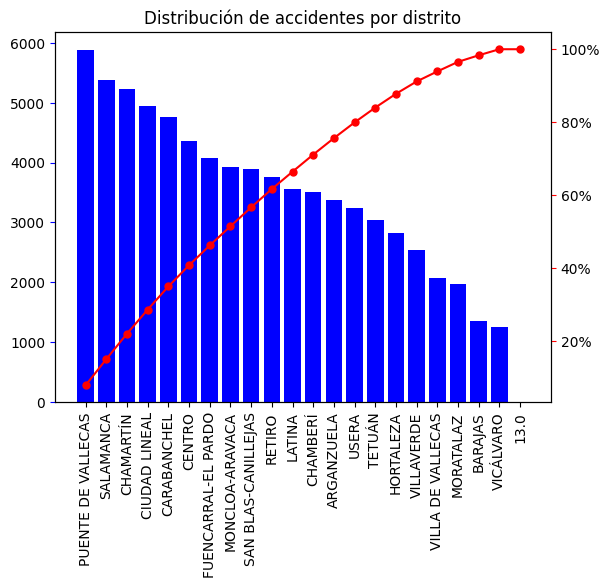

In [30]:
data_loader.data['datasets/accidentalidad']['DISTRITO'] = data_loader.data['datasets/accidentalidad']['DISTRITO'].astype(str)
CSVDataLoader.create_graph(data_loader.data['datasets/accidentalidad'], 'DISTRITO', 'accidentes por distrito')


Tabla comparativa que muestra los accidentes donde la persona que lo ha padecido ha dado positivo en alcohol.

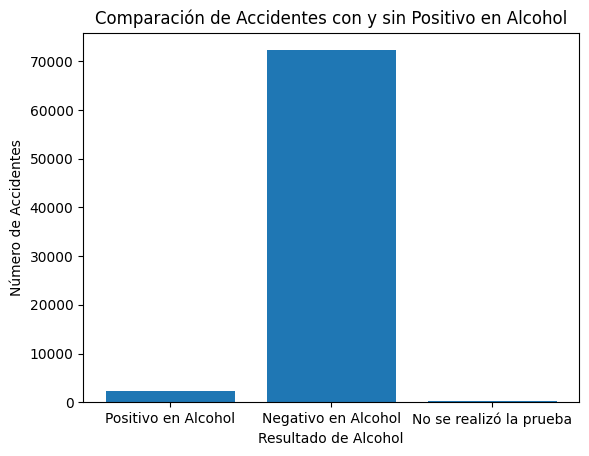

In [ ]:
accidentes = data_loader.data['datasets/accidentalidad']
positivos = accidentes[accidentes['POSITIVA_ALCOHOL'] == 'S']
negativos = accidentes[accidentes['POSITIVA_ALCOHOL'] == 'N']
labels = ['Positivo en Alcohol', 'Negativo en Alcohol', 'No se realizó la prueba']
values = [len(positivos), len(negativos), len(accidentes) - len(positivos) - len(negativos)]
plt.bar(labels, values)
plt.xlabel('Resultado de Alcohol')
plt.ylabel('Número de Accidentes')
plt.title('Comparación de Accidentes con y sin Positivo en Alcohol')
plt.show()

Tabla comparativo donde la persona que ha padecido el accidente ha dado positivo en drogas.

In [ ]:
accidentes = data_loader.data['datasets/accidentalidad']
positivos = accidentes[accidentes['POSITIVA_DROGA'] == 1]
negativos = accidentes[accidentes['POSITIVA_DROGA'] == 0]
labels = ['Positivo en Drogas', 'Negativo en Drogras', 'No se realizó la prueba']
values = [len(positivos), len(negativos), len(accidentes) - len(positivos) - len(negativos)]
plt.bar(labels, values)
plt.xlabel('Resultado de Alcohol')
plt.ylabel('Número de Accidentes')
plt.title('Comparación de Accidentes con y sin Positivo en Drogas')
plt.show()

Tabla comparativa que relaciona los accidente en los que la persona ha dado positivo en alcohol y drogas

In [ ]:
accidentes = data_loader.data['datasets/accidentalidad']
positivos_alcohol = accidentes[accidentes['POSITIVA_ALCOHOL'] == 'S']
positivos_drogas = accidentes[accidentes['POSITIVA_DROGA'] == 1]
positivos_alcohol_drogas = positivos_alcohol[positivos_alcohol['POSITIVA_DROGA'] == 1]
positivos_alcohol_drogas = len(positivos_alcohol_drogas)
negativos = len(accidentes) - positivos_alcohol_drogas
labels = ['Positivo en Alcohol y Drogas', 'Negativo en Alcohol y Drogas']
values = [positivos_alcohol_drogas, negativos]
plt.bar(labels, values)
plt.xlabel('Resultado de Alcohol')
plt.ylabel('Número de Accidentes')
plt.title('Comparación de Accidentes con y sin Positivo en Alcohol')
plt.show()

De estos datos podemos extraer que la policía no le asigna dato a negativo en drogas, ya que en todo el dataframe solo existe el valor "1". Por lo tanto, no se puede distinguir los casos en los que no se realiza la prueba o a dado negativo.